In [1]:
%pylab inline
import re
import pandas as pd
import gammastimator
import crystal
from importlib import reload

!git pull
!hostname

reflectionFN = 'test/reflections.csv.bz2'
imagedataFN = 'test/imagedata.csv.bz2'
referenceData  = 'test/dhfr/P21_Reference_Data.cns'
fcalcData    = 'test/dhfr/P21_Reference_Data_fmodel.cns'

spacegroupnumber = 4

Populating the interactive namespace from numpy and matplotlib


/n/home04/kmdalton/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Already up-to-date.
aaggpu03.rc.fas.harvard.edu


In [2]:
R = crystal.crystal().read_hkl(referenceData)
fcalc = crystal.crystal().read_hkl(fcalcData)
R['PHASE'] = fcalc['PHASE']
R.spacegroup = spacegroupnumber
R.unmerge()


SNR_CUTOFF = 0.1 #Minimum I/SIGMA(I)

I = pd.read_csv(reflectionFN)
I = I[I['IOBS']/I['SIGMA(IOBS)'] > SNR_CUTOFF]
#I['H'],I['K'] = I['K'],-I['H'] #Reindexing op for data integrated in P212121
I = crystal.crystal(I.set_index(['H', 'K', 'L']))
I.spacegroup = spacegroupnumber
I.populate_merged_hkls()

M = pd.read_csv(imagedataFN).set_index('Image#')
M['SERIES'] = M['file_name'].apply(lambda x: 'off' if 'off' in x else 'on') + M['file_name'].apply(lambda x: x.split('/')[-1].split('_')[0])
M['RUN'] = M['file_name'].apply(lambda x:int(re.search(r'(?<=r)[0-9]*', x).group()))
M['PHINUMBER'] = M['file_name'].apply(lambda x : int(re.search(r'(?<=_)[0-9]+(?=.tiff)', x).group()))

I = I.reset_index().merge(M.reset_index(), on='Image#')

keepcols = [
    'H',
    'K',
    'L',
    #'MERGEDH',
    #'MERGEDK',
    #'MERGEDL',
    'IOBS',
    'SIGMA(IOBS)',
    'ipm2',
    #'ipm3',
    'ipm2_xpos',
    #'ipm3_xpos',
    'ipm2_ypos',
    #'ipm3_ypos',
    'RUN',
    'PHINUMBER',
    'SERIES'
]

I = I[[i for i in keepcols]]
I = gammastimator.append_reference_data(I, R)
I = gammastimator.pare_data(I)

(3, 3566724)


/n/home04/kmdalton/opt/gammastimator/gammastimator.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe[k] = dataframe[k].astype(columns[k])
/n/home04/kmdalton/opt/gammastimator/gammastimator.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['on'] = dataframe.SERIES.str.contains('on')


In [ ]:
from time import time
from datetime import timedelta

bins = cc = None

binFN = "test/DHFR_DeltaFoverF/bins_scrambled_2.npy"
ccFN = "test/DHFR_DeltaFoverF/cc_scrambled_2.npy"


function = lambda x: gammastimator.sparsedeltaFestimate(x, 'ipm2_xpos', 'ipm2_ypos', 'ipm2', True)

start = time()
for i in range(20):
    print("{} : {}".format(i, str(timedelta(seconds=time() - start))))
    bins, cc_ = gammastimator.cchalf(I, function, 10)
    if cc is None:
        cc = cc_
    else:
        cc = np.vstack((cc, cc_))
    np.save(binFN, bins)
    np.save(ccFN, cc)
    print(" "*len("{}".format(i)) + "   {}".format(str(timedelta(seconds=time() - start))))

0 : 0:00:00.000240


In [6]:
I = gammastimator.pare_data(pd.read_csv(reflectionFN))
R = gammastimator.crystal.crystal().read_hkl(referenceFN)
R.spacegroup= spacegroup
R.unmerge()

/n/home04/kmdalton/opt/gammastimator/gammastimator.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe[k] = dataframe[k].astype(columns[k])


AttributeError: 'DataFrame' object has no attribute 'SERIES'

Text(0,0.5,'$\\frac {\\Delta F} {F}\\ \\ \\ \\ CC_{1/2}$')

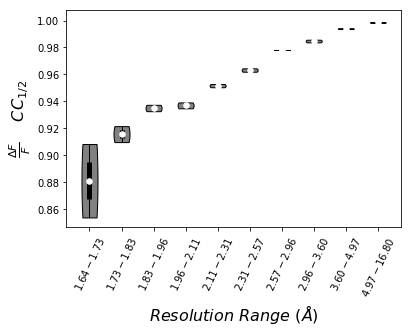

In [30]:
#binFN = 'test/DHFR_DeltaFoverF/bins.npy'
ccFN = 'test/DHFR_DeltaFoverF/cc_scrambled_2.npy'
binFN = 'test/DHFR_DeltaFoverF/bins_scrambled_2.npy'

cc = np.load(ccFN)
bins = np.load(binFN)

cc = np.vstack((i for i in cc if np.sum(np.isnan(i)) == 0))

parts = plt.violinplot(
        cc, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(cc, [25, 50, 75], axis=0)
whiskersMin, whiskersMax = np.min(cc, 0), np.max(cc, 0)

inds = np.arange(1, len(medians) + 1)
plt.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

plt.xticks(np.arange(len(bins)) + 1.0, [r'${:0.2f}-{:0.2f}$'.format(i, j) for i,j in bins], rotation=65)
plt.xlabel("$Resolution\ Range\ (\AA)$", fontsize=16)
plt.ylabel(r"$\frac {\Delta F} {F}\ \ \ \ CC_{1/2}$", fontsize=16)

Text(0,0.5,'$\\frac {\\Delta F} {F}\\ \\ \\ \\ CC_{1/2}$')

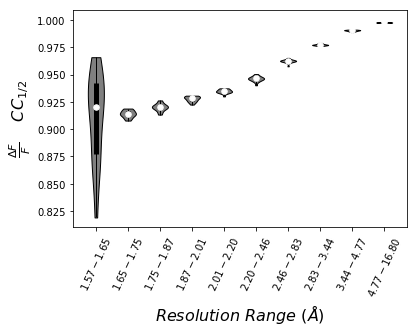

In [29]:
binFN = 'test/DHFR_DeltaFoverF/bins.npy'
ccFN  = 'test/DHFR_DeltaFoverF/cc.npy'

cc = np.load(ccFN)
bins = np.load(binFN)

cc = np.vstack((i for i in cc if np.sum(np.isnan(i)) == 0))

parts = plt.violinplot(
        cc, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(cc, [25, 50, 75], axis=0)
whiskersMin, whiskersMax = np.min(cc, 0), np.max(cc, 0)

inds = np.arange(1, len(medians) + 1)
plt.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

plt.xticks(np.arange(len(bins)) + 1.0, [r'${:0.2f}-{:0.2f}$'.format(i, j) for i,j in bins], rotation=65)
plt.xlabel("$Resolution\ Range\ (\AA)$", fontsize=16)
plt.ylabel(r"$\frac {\Delta F} {F}\ \ \ \ CC_{1/2}$", fontsize=16)